In [2]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import IntProgress
from IPython.display import display

import statsmodels.api as sm
from statsmodels.formula.api import ols

# Append base directory
import os,sys,inspect
rootname = "pub-2020-exploratory-analysis"
thispath = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
rootpath = os.path.join(thispath[:thispath.index(rootname)], rootname)
sys.path.append(rootpath)
print("Appended root directory", rootpath)

from mesostat.utils.qt_helper import gui_fnames, gui_fpath
from mesostat.metric.metric import MetricCalculator
from mesostat.utils.hdf5_io import DataStorage
from mesostat.stat.anova import as_pandas, as_pandas_lst, anova_homebrew

from lib.gallerosalas.data_fc_db_raw import DataFCDatabase
from lib.sych.metric_helper import metric_by_session

%load_ext autoreload
%autoreload 2

Appended root directory /home/alyosha/work/git/pub-2020-exploratory-analysis


In [3]:
params = {}
# params['root_path_data']  = gui_fpath("Path to data collection",  './')
params['root_path_data'] = '/media/alyosha/Data/TE_data/yasirdata_raw/'

In [4]:
dataDB = DataFCDatabase(params)

Reading channel label file
Reading allen brain map
Reading task structure
Searching for data files
Found mice ['mou_5', 'mou_6', 'mou_7', 'mou_9']


In [5]:
ds = DataStorage('gallerosalas_result_individual_region.h5')

In [6]:
mc = MetricCalculator(serial=True, verbose=False)

In [7]:
print('mice', dataDB.mice)
print('nSessions', len(dataDB.sessions))
print('datatypes', dataDB.get_data_types())
print('nChannel', dataDB.get_nchannels('mou_5'))

mice {'mou_7', 'mou_5', 'mou_6', 'mou_9'}
nSessions 4
datatypes ['raw', 'bn_session', 'bn_trial']
nChannel 28


# Analysis of Variance

* Across sessions
    - Explained by performance
* Across channels, trials, timesteps
    - Explained by trial type

Things to understand:
* How to compare different rows?
* What models make sense?
* Try linear mixed models?

In [8]:
intervDict = {
    "TEX" : [2.0, 4.0],
    "DEL" : [5.0, 6.8],
    "REW" : [7.0, 8.0]
}


#trialTypeNames = dataDB.get_trial_type_names()
trialTypeNames = ['Hit', 'CR']

dfDict = {}
for mousename in dataDB.mice:
    sessions = dataDB.get_sessions(mousename)
    dfThis = pd.DataFrame()
    for session in sessions:
        for trialType in trialTypeNames:
            dataTrialLst = []
            for intervName, interv in intervDict.items():
                data = dataDB.get_neuro_data({'session' : session}, datatype='bn_session', trialType=trialType, cropTime=interv)[0]
                data = np.mean(data, axis=1)  # Average over timesteps
                dataDF = as_pandas(data, ('trials', 'channels'))
                dataDF['trialType'] = trialType
                dataDF['interval'] = intervName
                dataDF['session'] = session
                dfThis = dfThis.append(dataDF, ignore_index=True)
            
    dfThis = dfThis.drop('trials', axis=1)
    dfDict[mousename] = dfThis

In [9]:
model = '''
    rez ~ C(channels)
    + C(trialType)
    + C(interval)
    + C(session)
    + C(trialType)*C(session)
    + C(trialType)*C(channels)
    + C(interval)*C(channels)
'''

# Session-wide
for mousename in sorted(dataDB.mice):
    print(mousename)
    linModel = ols(model, data=dfDict[mousename]).fit()
    display(sm.stats.anova_lm(linModel, typ=1))

mou_5


,df,sum_sq,mean_sq,F,PR(>F)
C(channels),26.0,0.402200,0.015469,179.534102,0.000000e+00
C(trialType),1.0,0.700699,0.700699,8132.236261,0.000000e+00
C(interval),2.0,4.665646,2.332823,27074.470673,0.000000e+00
C(session),20.0,0.079285,0.003964,46.008487,1.079655e-181
C(trialType):C(session),20.0,0.074324,0.003716,43.129959,1.695929e-169
C(trialType):C(channels),26.0,0.305508,0.011750,136.372708,0.000000e+00
C(interval):C(channels),52.0,0.477409,0.009181,106.553051,0.000000e+00
Residual,204296.0,17.602796,0.000086,NaN,NaN


mou_6


,df,sum_sq,mean_sq,F,PR(>F)
C(channels),26.0,0.131489,0.005057,61.576338,2.702539e-321
C(trialType),1.0,0.260928,0.260928,3177.008176,0.000000e+00
C(interval),2.0,4.764140,2.382070,29003.666241,0.000000e+00
C(session),29.0,0.446908,0.015411,187.637111,0.000000e+00
C(trialType):C(session),29.0,0.234505,0.008086,98.458444,0.000000e+00
C(trialType):C(channels),26.0,0.550052,0.021156,257.589681,0.000000e+00
C(interval):C(channels),52.0,0.749290,0.014409,175.446535,0.000000e+00
Residual,294188.0,24.161647,0.000082,NaN,NaN


mou_7


,df,sum_sq,mean_sq,F,PR(>F)
C(channels),26.0,0.522090,0.020080,154.879524,0.0
C(trialType),1.0,3.106250,3.106250,23958.411938,0.0
C(interval),2.0,3.565644,1.782822,13750.852232,0.0
C(session),26.0,0.361804,0.013916,107.330172,0.0
C(trialType):C(session),26.0,0.241200,0.009277,71.552752,0.0
C(trialType):C(channels),26.0,0.551924,0.021228,163.729835,0.0
C(interval):C(channels),52.0,0.869648,0.016724,128.991747,0.0
Residual,229070.0,29.699326,0.000130,NaN,NaN


mou_9


,df,sum_sq,mean_sq,F,PR(>F)
C(channels),26.0,0.055586,0.002138,11.845900,5.894292e-50
C(trialType),1.0,0.059399,0.059399,329.118844,1.722819e-73
C(interval),2.0,0.168306,0.084153,466.277440,9.734528e-203
C(session),21.0,0.091413,0.004353,24.119089,8.806232e-94
C(trialType):C(session),21.0,0.178130,0.008482,46.999262,5.586883e-195
C(trialType):C(channels),26.0,0.455559,0.017522,97.083432,0.000000e+00
C(interval):C(channels),52.0,0.535135,0.010291,57.020823,0.000000e+00
Residual,192063.0,34.663304,0.000180,NaN,NaN


mou_5
mou_6
mou_7
mou_9


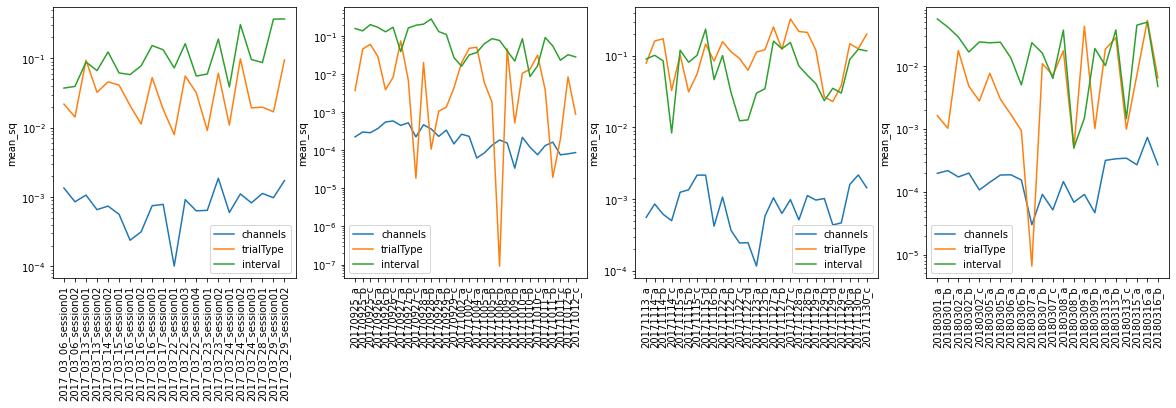

In [10]:
# Across-sessions
nMice = len(dataDB.mice)
fig, ax = plt.subplots(ncols = nMice, figsize=(5*nMice, 5))

model = '''
rez ~ C(channels)+C(trialType)+C(interval)
'''

for iMouse, mousename in enumerate(sorted(dataDB.mice)):
    dfThis = dfDict[mousename]
    print(mousename)
    sessions = dataDB.get_sessions(mousename)
    plotData = []
    for session in sessions:
        dfSession = dfThis[dfThis['session'] == session]
        linModel = ols(model, data=dfSession).fit()
        rezStat = sm.stats.anova_lm(linModel, typ=1)
        rezStat = rezStat.drop('Residual')
        plotData += [np.array(rezStat['mean_sq'])]

    names = ['channels', 'trialType', 'interval']
    plotData = np.array(plotData).T


    ax[iMouse].set_ylabel('mean_sq')
    for name, x in zip(names, plotData):
        ax[iMouse].semilogy(x, label=name)

    ax[iMouse].set_xticks(np.arange(len(sessions)))
    ax[iMouse].set_xticklabels(sessions, rotation=90)
    ax[iMouse].legend()

plt.savefig('pics/ANOVA_by_session.png')
plt.show()
plt.close()